* Extract cofactors (NADPH, NADH, ATP) balances
nadphs = ['nadph_c', 'nadph_m', 'nadph_x']
nadhs = ['nadh_c', 'nadh_m', 'nadh_x', 'nadh_r']
atps = ['atp_c', 'atp_m', 'atp_v', 'atp_n', 'atp_r'] 
* Include their all reactions (ID, name, equation) and  the cofactor balance in that reaction (flux) and % of total consumed/produced cofactor flux

In [1]:
import cobra
import pandas as pd
import os
from os.path import join
from cobra import Model, Reaction, Metabolite
from cobra.sampling import sampling
import numpy as np
os.environ["R_HOME"] = f"{os.environ['CONDA_PREFIX']}\\Lib\\R"
import rpy2.robjects
from plotnine import *
import matplotlib.pyplot as plt

# model1=cobra.io.read_sbml_model("C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Model_files\\iRhto_models\\iRhtoC.xml")
# model1.objective = "EX_glc__D_e" 



In [2]:
glucose_uptakes = [0.476, 1.114, 1.648, 2.305, 3.1] 
growth_rates = [0.033972, 0.082746, 0.12357, 0.173796, 0.234573]

In [3]:
# Cofactor lists
nadphs = ['nadph_c', 'nadph_l', 'nadph_m', 'nadph_r', 'nadph_rm','nadph_x']
nadhs = ['nadh_c', 'nadh_m', 'nadh_x', 'nadh_r', 'nadh_rm']
atps = ['atp_c', 'atp_m', 'atp_n', 'atp_r', 'atp_en', 'atp_gm', 'atp_l', 'atp_rm', 'atp_vm', 'atp_x'] 


In [4]:
# Make a function for getting cofactor fluxes (all reactions where given metabolite is and their fluxes)

def cofactor_all_rxn_fluxes(cofactor_list, i):
    producing_fluxes = pd.DataFrame() 
    consuming_fluxes = pd.DataFrame()
    
    model=cobra.io.read_sbml_model("C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Model_files\\iRhto_models\\iRhtoC.xml")
    model.objective = "ATPM_c"  
    model.reactions.EX_glc__D_e.bounds = -(glucose_uptakes[i]), -(glucose_uptakes[i])
    model.reactions.BIOMASS_RT_CLIM.bounds = growth_rates[i], growth_rates[i]
    
    solution = model.optimize('minimize') 

    for metabolite in cofactor_list:
        producing_fluxes = pd.concat([producing_fluxes, getattr(model.metabolites, metabolite).summary().producing_flux])
        consuming_fluxes = pd.concat([consuming_fluxes, getattr(model.metabolites, metabolite).summary().consuming_flux])
    
    for reaction in producing_fluxes.index:
        if reaction in consuming_fluxes.index and abs(round(producing_fluxes.loc[reaction, 'flux'], 3)) == abs(round(consuming_fluxes.loc[reaction, 'flux'], 3)):
            producing_fluxes = producing_fluxes.drop([reaction])
            consuming_fluxes = consuming_fluxes.drop([reaction])
            
    cofactor_fluxes = pd.concat([producing_fluxes, consuming_fluxes])

    cofactor_fluxes = cofactor_fluxes.sort_values(by='flux', ascending=False).drop(columns = ['percent']) # drop percent column, bc these percents are not for nadph sum (the percent is for specific compartment)
    cofactor_fluxes = cofactor_fluxes[(cofactor_fluxes['flux']) != 0.0] # for getting non-zero fluxes only

    cofactor_sum_producing_flux = sum(cofactor_fluxes[cofactor_fluxes['flux'] > 0]['flux']) # for getting the sum of producing fluxes
    cofactor_sum_consuming_flux = sum(cofactor_fluxes[cofactor_fluxes['flux'] < 0]['flux']) # for getting the sum of consumed fluxes
    print(f'SUM produced: {cofactor_sum_producing_flux}, SUM consumed: {cofactor_sum_consuming_flux}')

    if round(cofactor_sum_producing_flux, 3) == round(abs(cofactor_sum_consuming_flux), 3):
        cofactor_fluxes['percent'] = abs(cofactor_fluxes['flux']/cofactor_sum_producing_flux) # add percent column

    return cofactor_fluxes

In [14]:
# Making a pie chart
def cofactor_fluxes_pie_chart(cofactor_fluxes,  title):
    threshold =0.05# threshold shows the percent of the flux for including in others sector on pie chart 
    # The three lines below are for grouping together reactions with low fluxes in producing
    producing_cofactor_fluxes_draw = cofactor_fluxes[(cofactor_fluxes['flux'] > 0).copy()]    
    producing_cofactor_fluxes_draw.loc[producing_cofactor_fluxes_draw['percent'] < threshold, 'reaction'] = 'Other producing'
    producing_cofactor_fluxes_draw = producing_cofactor_fluxes_draw.groupby('reaction')[['percent', 'flux']].sum()        
    
    # The three lines below are for grouping together reactions with low fluxes in consuming 
    consuming_cofactor_fluxes_draw = cofactor_fluxes[(cofactor_fluxes['flux'] < 0).copy()]
    consuming_cofactor_fluxes_draw.loc[consuming_cofactor_fluxes_draw['percent'] < threshold, 'reaction'] = 'Other consuming'
    consuming_cofactor_fluxes_draw = consuming_cofactor_fluxes_draw.groupby('reaction')[['percent', 'flux']].sum()
    
    # y_producing = producing_cofactor_fluxes_draw['percent']
    # labels_producing = producing_cofactor_fluxes_draw[['reaction', 'flux']] 
    
    # y_consuming = abs(consuming_cofactor_fluxes_draw['percent'])
    # labels_consuming = consuming_cofactor_fluxes_draw[['reaction', 'flux']]
    
    producing_and_consuming_fluxes = pd.concat([producing_cofactor_fluxes_draw, consuming_cofactor_fluxes_draw])
    
    # reaction_IDs = pd.concat([labels_producing, labels_consuming])
    model=cobra.io.read_sbml_model("C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Model_files\\iRhto_models\\iRhtoC.xml")
    model.objective = "ATPM_c"
    solution = model.optimize('minimize')  
    
    reaction_names_w_flux = []
    for reaction in producing_and_consuming_fluxes.index:
        if reaction != 'Other producing' and reaction != 'Other consuming':
            reaction_names_w_flux += [''.join([''.join([str(round((producing_and_consuming_fluxes.loc[reaction, 'percent'])*100, 1)),'% ']), getattr(model.reactions, reaction).name, ' (', str(round(producing_and_consuming_fluxes.loc[reaction, 'flux'], 2)), ')'])]
        elif reaction == 'Other producing':
            reaction_names_w_flux += [''.join([''.join([str(round((producing_and_consuming_fluxes.loc[reaction, 'percent'])*100, 1)),'% ']), 'Other producing', ' (', str(round(producing_and_consuming_fluxes.loc[reaction, 'flux'], 2)), ')'])] 
        elif reaction == 'Other consuming':
            reaction_names_w_flux += [''.join([''.join([str(round((producing_and_consuming_fluxes.loc[reaction, 'percent'])*100, 1)),'% ']), 'Other consuming', ' (', str(round(producing_and_consuming_fluxes.loc[reaction, 'flux'], 2)), ')'])] 
    fig = plt.figure()
            
    pie_chart = plt.pie(producing_and_consuming_fluxes.loc[:, 'percent'], labels = reaction_names_w_flux)  #autopct='%1.1f%%' pd.concat([producing_cofactor_fluxes_draw, consuming_cofactor_fluxes_draw])[['flux', 'percent']]
    # plt.legend(producing_and_consuming_fluxes, reaction_names_w_flux, title = 'Reaction names', loc="center left",  bbox_to_anchor=(1, 0, 0.5, 1))
    # plt.title(title)

    
    return pie_chart, fig

In [6]:
# import pickle

# with open("../cofactor_comparison/iRhtoC_NGAM_cofactors.pk", "wb") as f:
#     pickle.dump([nadph_fluxes_lowest_GR, nadph_fluxes_highest_GR, nadh_fluxes_lowest_GR, nadh_fluxes_highest_GR, atp_fluxes_lowest_GR, atp_fluxes_highest_GR], f)


In [7]:
# Get nadph fluxes at lowest biomass growth rate

nadph_fluxes_lowest_GR = cofactor_all_rxn_fluxes(nadphs, 0)
nadph_fluxes_lowest_GR

# Get nadph fluxes at highest biomass growth rate

nadph_fluxes_highest_GR = cofactor_all_rxn_fluxes(nadphs, 4)
nadph_fluxes_highest_GR

# Get nadh fluxes at lowest biomass growth rate

nadh_fluxes_lowest_GR = cofactor_all_rxn_fluxes(nadhs, 0)
nadh_fluxes_lowest_GR

# Get nadh fluxes at highest biomass growth rate

nadh_fluxes_highest_GR = cofactor_all_rxn_fluxes(nadhs, 4)
nadh_fluxes_highest_GR

# Get atp fluxes at lowest biomass growth rate

atp_fluxes_lowest_GR = cofactor_all_rxn_fluxes(atps, 0)
atp_fluxes_lowest_GR

# Get atp fluxes at highest biomass growth rate

atp_fluxes_highest_GR = cofactor_all_rxn_fluxes(atps, 4)
atp_fluxes_highest_GR


Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-21
SUM produced: 0.5463436842551493, SUM consumed: -0.546343684253533
SUM produced: 3.772444278979949, SUM consumed: -3.7724442790076154
SUM produced: 2.997362991356737, SUM consumed: -2.997362991356767
SUM produced: 18.45572391887473, SUM consumed: -18.455723918870298
SUM produced: 8.822356843209032, SUM consumed: -8.822356753957653
SUM produced: 53.522966295256545, SUM consumed: -53.52296629524838


,flux,reaction,percent
ATPS_m,43.033184,ATPS_m,0.804013
PGK_c,4.571855,PGK_c,0.085419
PYK_c,4.229565,PYK_c,0.079023
SUCOAS_m,1.659429,SUCOAS_m,0.031004
FTHFL_m,0.028934,FTHFL_m,0.000541
...,...,...,...
ADK1_c,-1.258959,ADK1_c,0.023522
ACITL_c,-1.293863,ACITL_c,0.024174
PFK_c,-1.490907,PFK_c,0.027855
HEX1_c,-3.100000,HEX1_c,0.057919


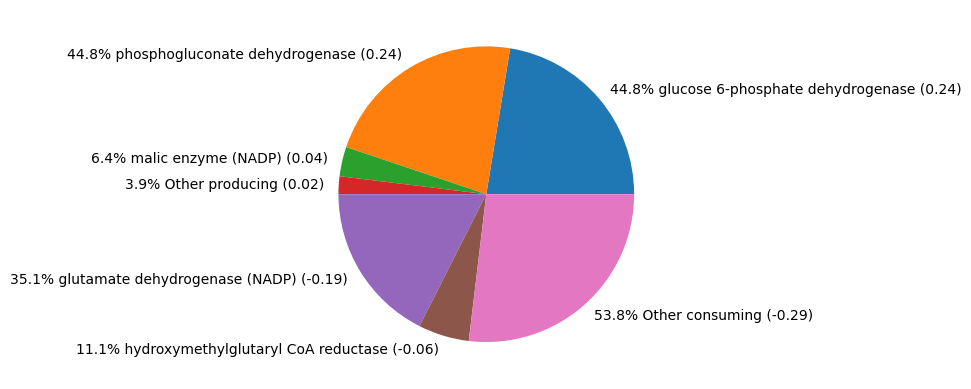

In [15]:
# Make a pie plot for napdh
threshold = 0.02 # threshold for including reaction in 'others' in pie chart
title = f'iRhtoC NADPH producing and conusming fluxes (glucose uptake = {glucose_uptakes[0]})'
producing_nadph_fluxes_lowest_GR_pie_chart, fig = cofactor_fluxes_pie_chart(nadph_fluxes_lowest_GR, title)
producing_nadph_fluxes_lowest_GR_pie_chart

fig.savefig("..\\..\\Thesis_paper_latex\\Pictures\\iRhtoC_nm_NADPH_min.png")

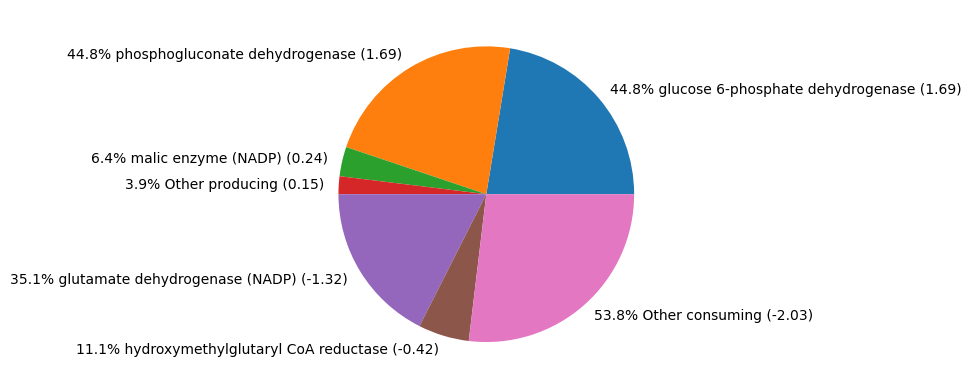

In [16]:
# Make a pie plot for napdh
threshold = 0.02 # threshold for including reaction in 'others' in pie chart
title = f'iRhtoC NADPH producing and conusming fluxes (glucose uptake = {glucose_uptakes[4]})'
producing_nadph_fluxes_highest_GR_pie_chart, fig = cofactor_fluxes_pie_chart(nadph_fluxes_highest_GR, title)
producing_nadph_fluxes_highest_GR_pie_chart

fig.savefig("..\\..\\Thesis_paper_latex\\Pictures\\iRhtoC_nm_NADPH_max.png")

([<matplotlib.patches.Wedge at 0x1e912a2cdd0>,
 [Text(1.0234239526513964, 0.40324113522728844, '23.9% glyceraldehyde-3-phosphate dehydrogenase (0.72)'),
  Text(0.6784316761164064, 0.8658697712946697, '9.9% glycine-cleavage complex (lipoamide) (0.3)'),
  Text(0.35891850348884946, 1.0397968589360735, '11.3% isocitrate dehydrogenase (NAD+) (0.34)'),
  Text(-0.4041346693040075, 1.0230714388871094, '33.9% malate dehydrogenase (1.01)'),
  Text(-0.9017987701953412, 0.6298880678931539, '3.4% Other producing (0.1)'),
  Text(-1.0576645287159392, 0.3022345855392631, '17.7% pyruvate dehydrogenase (0.53)'),
  Text(-1.0145501567347182, -0.42507408703608274, '25.3% malate dehydrogenase (-0.76)'),
  Text(0.40906280826454655, -1.0211109728598176, '73.7% NADH:ubiquinone oxidoreductase (complex I) (-2.21)'),
  Text(1.0998639083522432, -0.017302690661525236, '1.0% Other consuming (-0.03)')])

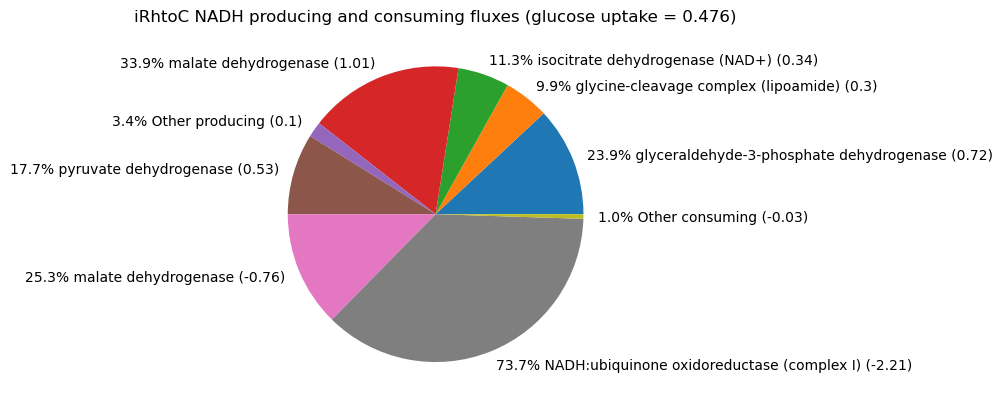

In [ ]:
# Make a pie plot for nadh 
threshold = 0.02 # threshold for including reaction in group 'others' in pie chart
title = f'iRhtoC NADH producing and consuming fluxes (glucose uptake = {glucose_uptakes[0]})'
producing_nadh_fluxes_lowest_GR_pie_chart, fig = cofactor_fluxes_pie_chart(nadh_fluxes_lowest_GR, title, threshold)
producing_nadh_fluxes_lowest_GR_pie_chart

([<matplotlib.patches.Wedge at 0x1e90e9bc560>,
 [Text(1.017768468487536, 0.4173096506822428, '24.8% glyceraldehyde-3-phosphate dehydrogenase (4.57)'),
  Text(0.6656616261644176, 0.875725184890867, '9.1% glycine-cleavage complex (lipoamide) (1.68)'),
  Text(0.3678150198842135, 1.0366832260375276, '10.6% isocitrate dehydrogenase (NAD+) (1.96)'),
  Text(-0.38576293275188644, 1.030139291413867, '33.9% malate dehydrogenase (6.26)'),
  Text(-0.8951645723243009, 0.6392811497732837, '3.8% Other producing (0.7)'),
  Text(-1.0570554880065788, 0.30435784083077944, '17.8% pyruvate dehydrogenase (3.29)'),
  Text(-1.0074491461505664, -0.4416403717058656, '26.3% malate dehydrogenase (-4.85)'),
  Text(0.4238007690042816, -1.0150827100248432, '72.6% NADH:ubiquinone oxidoreductase (complex I) (-13.39)'),
  Text(1.0998288541313768, -0.019403391973130887, '1.1% Other consuming (-0.21)')])

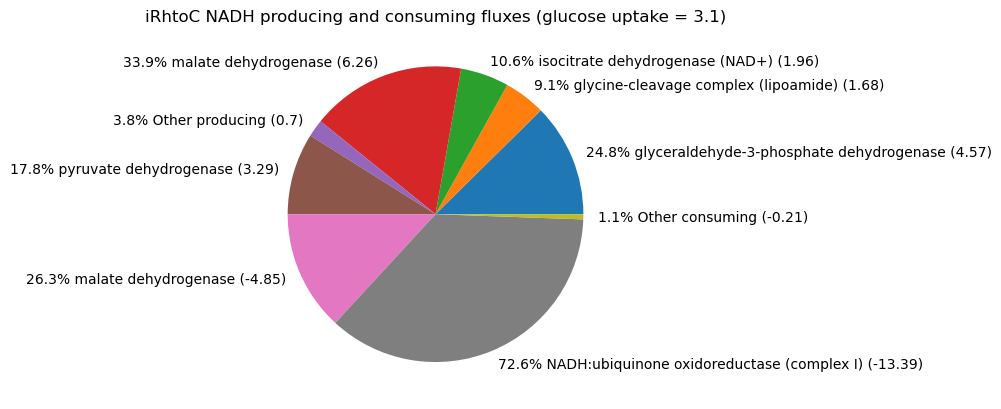

In [ ]:
# Make a pie plot for nadh 
threshold = 0.02 # threshold for including reaction in group 'others' in pie chart
title = f'iRhtoC NADH producing and consuming fluxes (glucose uptake = {glucose_uptakes[4]})'
producing_nadh_fluxes_highest_GR_pie_chart, fig = cofactor_fluxes_pie_chart(nadh_fluxes_highest_GR, title, threshold)
producing_nadh_fluxes_highest_GR_pie_chart


([<matplotlib.patches.Wedge at 0x1e90cbdcfe0>,
 [Text(0.32441598144382783, 1.0510729142090183, '80.9% ATP synthase (7.14)'),
  Text(-0.9091064247189372, 0.619294363396561, '0.0% Other producing (0.0)'),
  Text(-0.9808541929061917, 0.49792072888999456, '8.1% phosphoglycerate kinase (0.72)'),
  Text(-1.0726329615006445, 0.24384119812360916, '7.6% pyruvate kinase (0.67)'),
  Text(-1.0984890637653948, 0.05763485740267217, '3.3% succinate-CoA ligase (ADP-forming) (0.29)'),
  Text(-1.0993878536824768, -0.03669260382470767, '2.1% ATP citrate lyase (-0.19)'),
  Text(-1.0945932501608289, -0.10892941155791469, '2.1% adenylate kinase (-0.18)'),
  Text(-1.0357942331489556, -0.3703110943185028, '13.5% ATP maintenance requirement (-1.19)'),
  Text(-0.007812790326235596, -1.0999722543352257, '64.2% Biomass_Rt_Clim (-5.67)'),
  Text(0.9733942846317838, -0.5123510189764221, '5.4% hexokinase (D-glucose:ATP) (-0.48)'),
  Text(1.0676460009378523, -0.2648245016636709, '10.0% Other consuming (-0.88)'),
  Te

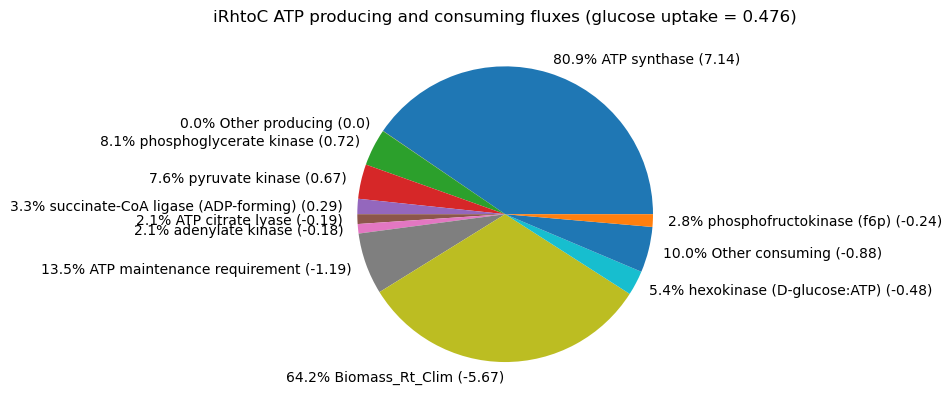

In [ ]:
# Make a pie plot for atp 
threshold = 0.02 # threshold for including reaction in group 'others' in pie chart
title = f'iRhtoC ATP producing and consuming fluxes (glucose uptake = {glucose_uptakes[0]})'
producing_atp_fluxes_lowest_GR_pie_chart, fig = cofactor_fluxes_pie_chart(atp_fluxes_lowest_GR, title,  threshold)
producing_atp_fluxes_lowest_GR_pie_chart

([<matplotlib.patches.Wedge at 0x1e90e0ce780>,
 [Text(0.33331668051412966, 1.0482843080438826, '80.4% ATP synthase (43.03)'),
  Text(-0.898539119528248, 0.6345293142774421, '0.1% Other producing (0.03)'),
  Text(-0.9757774540062479, 0.5077975583370649, '8.5% phosphoglycerate kinase (4.57)'),
  Text(-1.0731182443285903, 0.2416965735982295, '7.9% pyruvate kinase (4.23)'),
  Text(-1.0986957727400184, 0.05354996697677713, '3.1% succinate-CoA ligase (ADP-forming) (1.66)'),
  Text(-1.0992070489186754, -0.04175959299965748, '2.4% ATP citrate lyase (-1.29)'),
  Text(-1.0929978097911766, -0.12391847235860891, '2.4% adenylate kinase (-1.26)'),
  Text(-1.0812832054669528, -0.20205600603573137, '2.2% ATP maintenance requirement (-1.19)'),
  Text(-0.2219596170548404, -1.0773736252558204, '73.1% Biomass_Rt_Clim (-39.12)'),
  Text(0.9462923797891601, -0.5608303949974255, '5.8% hexokinase (D-glucose:ATP) (-3.1)'),
  Text(1.0613800383973038, -0.2889159291069602, '11.3% Other consuming (-6.07)'),
  Text

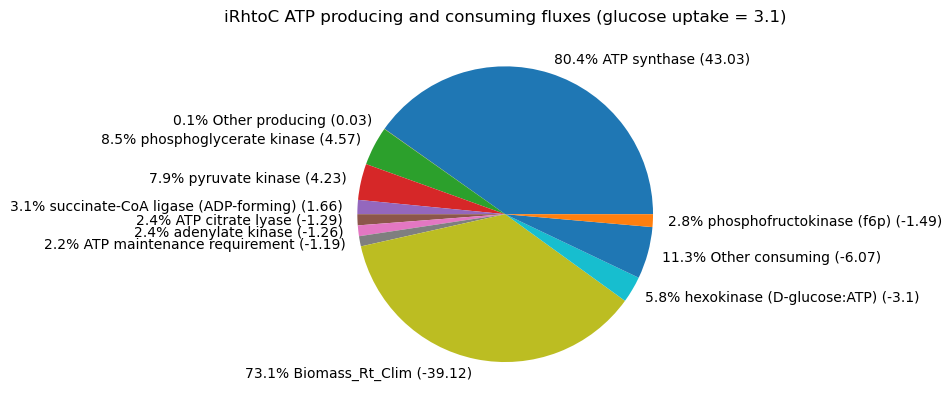

In [ ]:
# Make a pie plot for atp 
threshold = 0.02 # threshold for including reaction in group 'others' in pie chart
title = f'iRhtoC ATP producing and consuming fluxes (glucose uptake = {glucose_uptakes[4]})'
producing_atp_fluxes_highest_GR_pie_chart, fig = cofactor_fluxes_pie_chart(atp_fluxes_highest_GR, title,  threshold)
producing_atp_fluxes_highest_GR_pie_chart

In [ ]:
# # Get cofactor data to excel
# with pd.ExcelWriter('C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Results\\iRhto_results\\iRhto_all_cofactor_fluxes.xlsx') as excel_writer:
#     nadph_fluxes_lowest_GR.to_excel(excel_writer, sheet_name=f'NADPH fluxes, GR = {growth_rates[0]}', index=False)
#     nadph_fluxes_highest_GR.to_excel(excel_writer, sheet_name=f'NADPH fluxes, GR = {growth_rates[5]}', index=False)
#     nadh_fluxes_lowest_GR.to_excel(excel_writer, sheet_name=f'NADH fluxes, GR = {growth_rates[0]}', index=False)
#     nadh_fluxes_highest_GR.to_excel(excel_writer, sheet_name=f'NADH fluxes, GR = {growth_rates[5]}', index=False)
#     atp_fluxes_lowest_GR.to_excel(excel_writer, sheet_name=f'ATP fluxes, GR = {growth_rates[0]}', index=False)
#     atp_fluxes_highest_GR.to_excel(excel_writer, sheet_name=f'ATP fluxes, GR = {growth_rates[5]}', index=False)

    